In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import matplotlib.dates as mdates

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**How to use date**
- month, date, currency, stock level, customer로 분석
- Shiprocket and INCREF 두가지 창고 관리(?), 수요 공급 방식 비교/검토
- Amazon FBA MRP, Myntra MRP, Ajio MRP의 비교로 어느 것이 더 수익성이 좋은가?
- TP 1/TP 2 해석이 좀 애매하다
- P & L Data, Yearly Expenses_IIGF

**Ideas**
 - Shiprocket and INCREFF의 비교로 어느 것이 profit margin이 큰가?
 - 중간값, 재료값, 마지막 값의 비교...?
 - 미래 수요와 공급을 예측한다. -> 단순히 하나의 item, 아이템 브랜드로 묶어서, 지역 단위를 나눠볼까, 근데 이게 배송이 있다는 거는 대부분 온라인 쇼핑일 거고 온라인 쇼핑에서 수요 공급을 에측하는데 지역 단위는 크게 중요하지 않을 것 같아. 그러니 지역은 후순위에 둬보고, 
 - user based recommendation system **구축 완료 2023/01/13**<br>
   International sale Report data의 costumer 기준으로 extract insight: user based recommendation 
 - 

**보완할 점**


**현재 진행 상황**
- ama_sale에서 배송 상태에 관한 정보와 다른 정보의 관계를 찾아보려해 **2023.01.24**
- **배송 지역에 대한 정보**를 바탕으로 새로운 네트워크 망을 구축해보자. 지역에 관하여 네트워크 망을 구축하려면 최소한의 위도, 경도 정보가 있어야한다. 하지만 현재 주어진 데이터에는 위도, 경도에 관한 정보가 없으므로 위 주제 폐기
- 단순히 가까운 지역이 아니라 날짜를 이용하여? 효율적으로 만들려면 어떻게 해야할까? 
- amazon과 merchant는 서로 상반되는 관계를 가지는 것 같다. 상반되는 관계 속에서 극한의 이익을 추구하려면 어떻게 해야할 것인가? 먼저 전략을 택해야 한다. a가 잘 팔릴 때 a를 더 밀어줄 것인가? 아니면 m의 저조한 판매 실적을 끌어 올릴 것인가? 물 들어올 때 노 저을지, 아니면 계란을 한 바구니에 두지 않을지 골라야 한다
- 어느 시기에 어느 제품이 잘 팔렸을까?
- style_alphabet과 fulfilment의 추세를 비교하기 위해 그래프를 그렸다. 그런데 눈으로 보니 좀 복잡해서 보기좋은 그래프를 다시 그려보고 그래프만이 아니라 수식을 통해서 amazon과 fulfilment 중 하나를 선택을 해봐야겠다

# Amazon Sale Report 

## Preprocessing

In [ ]:
def summary_df(dataset):
  print("shape of dataset: ", dataset.shape)
  print("\n\ninformation of dataset"); print(dataset.info())
  print("\n\ndescribtion of dataset"); print(dataset.describe()) 
  dataset_obj = dataset.select_dtypes(include = [object, bool])
  dataset_num = dataset.select_dtypes(exclude = [object, bool])

  return [dataset_obj, dataset_num]

In [ ]:
ama_sale = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Dataset/amazon/Amazon Sale Report.csv")
ama_sale.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [ ]:
ama_sale_obj, ama_sale_num = summary_df(ama_sale)

shape of dataset:  (128975, 24)


information of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 

In [ ]:
ama_sale.loc[:,"Date"] = pd.to_datetime(ama_sale.loc[:, "Date"])
ama_sale.loc[:,"Date"]

0        2022-04-30
1        2022-04-30
2        2022-04-30
3        2022-04-30
4        2022-04-30
            ...    
128970   2022-05-31
128971   2022-05-31
128972   2022-05-31
128973   2022-05-31
128974   2022-05-31
Name: Date, Length: 128975, dtype: datetime64[ns]

## Visualization with Date

Text(0, 0.5, 'count of sale')

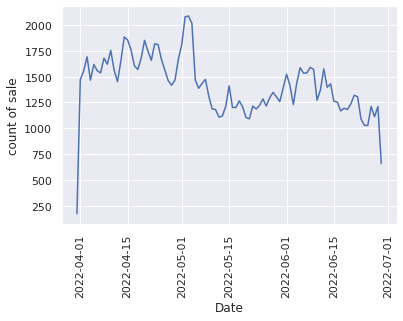

In [ ]:
ama_sale_count_date = ama_sale.groupby("Date")["Fulfilment"].count()
plt.plot(ama_sale_count_date)
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("count of sale")

Date와 Fulfilment로 groupby 후 count하여 각 fulfilment의 scatter plot

In [ ]:
count_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["index"].count().to_frame().reset_index(level = "Fulfilment")

count_amaz_ama = count_ama_fulfil_sale[count_ama_fulfil_sale["Fulfilment"] == "Amazon"].loc[:,"index"]
count_merc_ama = count_ama_fulfil_sale[count_ama_fulfil_sale["Fulfilment"] == "Merchant"].loc[:,"index"]

count_amaz_ama

Date
2022-03-31     148
2022-04-01    1147
2022-04-02    1216
2022-04-03    1282
2022-04-04    1083
              ... 
2022-06-25     778
2022-06-26     876
2022-06-27     775
2022-06-28     864
2022-06-29     445
Name: index, Length: 91, dtype: int64

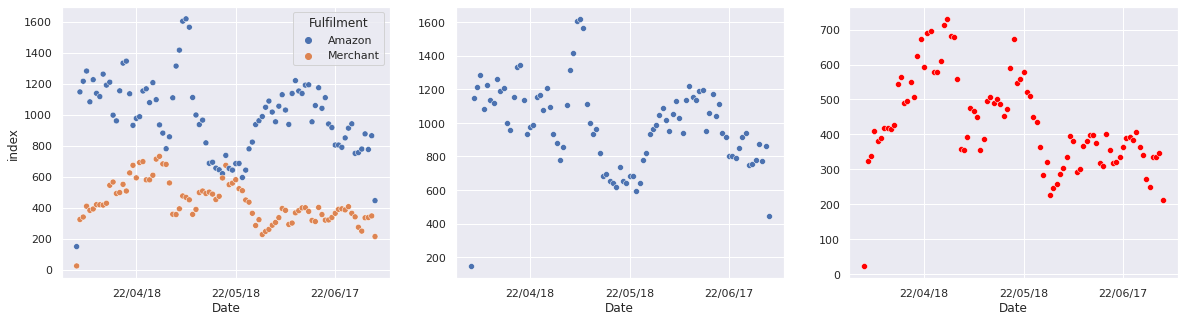

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,5)); axes.flatten()

sns.scatterplot(x = "Date", y = 'index', data = count_ama_fulfil_sale, hue = "Fulfilment", ax = axes[0])
sns.scatterplot(x = "Date", y = count_amaz_ama.values, data = count_amaz_ama, ax = axes[1])
sns.scatterplot(x = "Date", y = count_merc_ama.values, data = count_merc_ama, ax = axes[2], color = "red")

for i in range(3):
  axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=30))
  axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))

#### amazon과 merchant는 서로 상반되는 관계를 가지는 것 같다.<br>
당연한 게 방식이 두 가지인데 하나를 많이 쓰면 남은 하나는 적게 쓰겠지 <br>
amount와 count의 추세가 거의 일치하는 것으로 보인다. <br>
4, 6월 에는 15일 동안 4번의 변화가 생기는 것 같다 <br>
반면 5월에는 Amazon과 Merchant에서 변화 폭이 상당해 둘다 급락, 급상승의 시기가 존재하지 <br> 
그럼에도 분포에서 15일간 4번의 변화가 있음을 시사하는 부분들이 있어 그럼 내가 해야할 것은 **5월은 다른 시기와 어떤 차이가 있었을 것인가?** <br>
**그리고 가장 중요하게 Amazon과 Merchant의 상승, 하강은 다른 변수들과 어떤 관계에 놓여있을 것인가?** <br>
후보: 특정 city에서 주문량 급변, 

(array([19083., 19097., 19113., 19127., 19144., 19158., 19174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

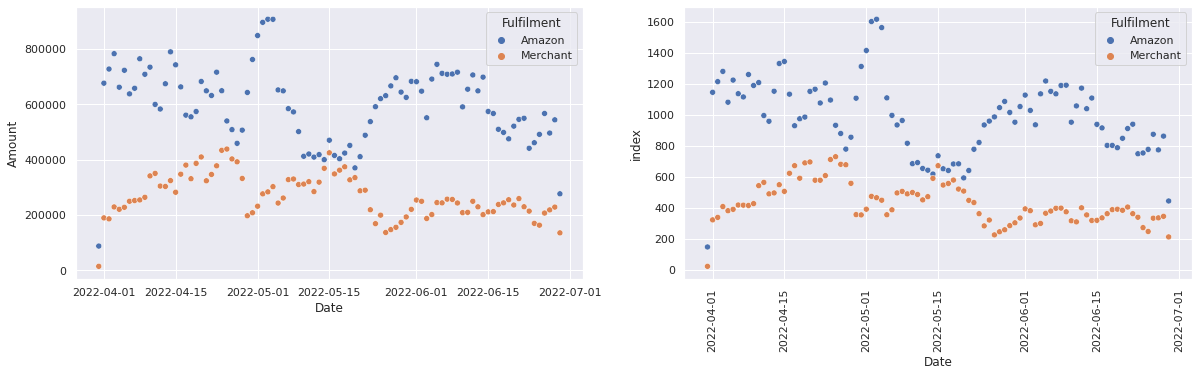

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

sum_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["Amount"].sum().to_frame().reset_index(level = "Fulfilment")
count_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["index"].count().to_frame().reset_index(level = "Fulfilment")


sns.scatterplot(x = "Date", y = 'Amount', data = sum_ama_fulfil_sale, hue = "Fulfilment", ax = axes[0])
sns.scatterplot(x = "Date", y = 'index', data = count_ama_fulfil_sale, hue = "Fulfilment", ax = axes[1])
plt.xticks(rotation='vertical')

In [ ]:
ama_sale.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN


In [ ]:
len(ama_sale["ship-city"].unique())

8956

In [ ]:
ama_sale.groupby(["Date", "ship-city"])["index"].count().unique()

array([  1,   2,   3,  16,   8,   4,   5,   9,   6,  11, 129,  63,  10,
        15,  73,  19,  33,  55,   7,  17,  70,  40,  12, 127,  13,  81,
        14,  20,  74,  30,  25,  64,  83,  32, 160,  71,  18,  77,  27,
        98,  96,  46, 124,  56,  29,  76,  22,  47,  23, 138,  61,  89,
        79,  49, 151,  59,  45,  82,  72,  38, 125,  35,  87,  28, 109,
        52, 102,  48,  26, 181,  80,  85,  36,  93, 137,  34,  95,  24,
        21, 103,  75,  31,  44, 158,  53, 105,  86,  43, 166,  66,  78,
       152, 106,  84,  90,  50, 146,  51,  37,  94, 117,  67,  68,  41,
       135,  54, 140,  62,  91,  69, 120,  97,  57, 134, 128, 118, 107,
       131,  60, 115,  99, 136, 101,  42,  92, 142, 119,  58, 110, 185,
       165,  88, 172, 123,  65, 122, 126, 111, 112, 113, 114,  39, 108,
       198, 170, 116, 176, 141, 153, 156, 154, 104, 100])

In [ ]:
city_over_10 = ama_sale.groupby(["Date", "ship-city"])["index"].count() >= 10
ama_sale.groupby(["Date", "ship-city"])["index"].count()[city_over_10].to_frame().reset_index(level = "ship-city")

,ship-city,index
Date,,
2022-03-31,BENGALURU,16
2022-04-01,AHMEDABAD,11
2022-04-01,BANGALORE,11
2022-04-01,BENGALURU,129
2022-04-01,CHENNAI,63
...,...,...
2022-06-29,MUMBAI,35
2022-06-29,NEW DELHI,23
2022-06-29,PUDUCHERRY,13


In [ ]:
ama_sale['Sales Channel '].unique()

array(['Amazon.in', 'Non-Amazon'], dtype=object)

In [ ]:
ama_sale.groupby('Sales Channel ').count()

,index,Order ID,Date,Status,Fulfilment,ship-service-level,Style,SKU,Category,Size,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
Sales Channel,,,,,,,,,,,,,,,,,,,,,
Amazon.in,128851,128851,128851,128851,128851,128851,128851,128851,128851,128851,...,121180,121180,128818,128818,128818,128818,79822,128851,39277,79854
Non-Amazon,124,124,124,124,124,124,124,124,124,124,...,0,0,124,124,124,124,0,124,0,71


In [ ]:
sum_ama_channel_sale = ama_sale.groupby(["Date", "Sales Channel "])["Amount"].sum().to_frame().reset_index(level = "Sales Channel ")
sum_ama_channel_sale

,Sales Channel,Amount
Date,,
2022-03-31,Amazon.in,101683.85
2022-04-01,Amazon.in,865478.60
2022-04-02,Amazon.in,913101.53
2022-04-03,Amazon.in,1011763.38
2022-04-04,Amazon.in,882059.17
...,...,...
2022-06-25,Amazon.in,654234.58
2022-06-26,Amazon.in,773610.02
2022-06-27,Amazon.in,714124.67


In [ ]:
sum_ama_channel_sale[sum_ama_channel_sale["Sales Channel "] == "Non-Amazon"]
# 날짜로 amazon과 non-amazon을 보기에는 non-amazon 숫자가 턱없이 부족한 것 같다.

,Sales Channel,Amount
Date,,
2022-04-04,Non-Amazon,0.0
2022-04-06,Non-Amazon,0.0
2022-04-09,Non-Amazon,0.0
2022-04-14,Non-Amazon,0.0
2022-04-18,Non-Amazon,0.0
2022-04-19,Non-Amazon,0.0
2022-04-22,Non-Amazon,0.0
2022-04-28,Non-Amazon,0.0
2022-04-30,Non-Amazon,0.0


### sale channel에서 non-amazon이 비는 날짜가 있다.

sales channel에서 amazon.in과 non-amazon의 비교

In [ ]:
sum_ama_ama = sum_ama_channel_sale[sum_ama_channel_sale["Sales Channel "] == "Amazon.in"].loc[:,"Amount"]
sum_ama_nonama = sum_ama_channel_sale[sum_ama_channel_sale["Sales Channel "] == "Non-Amazon"].loc[:,"Amount"]

non-amazon은 그냥 없네... 그냥 버려야 하나<br>
다행인 건 위에서 그렸던 plot들과 비슷향 동향을 보이는 것 같기도 하니 나중에 한 번에 plot을 그려서 전체적인 동향을 파악하고 뭔가 추가적으로 설계를 해보자

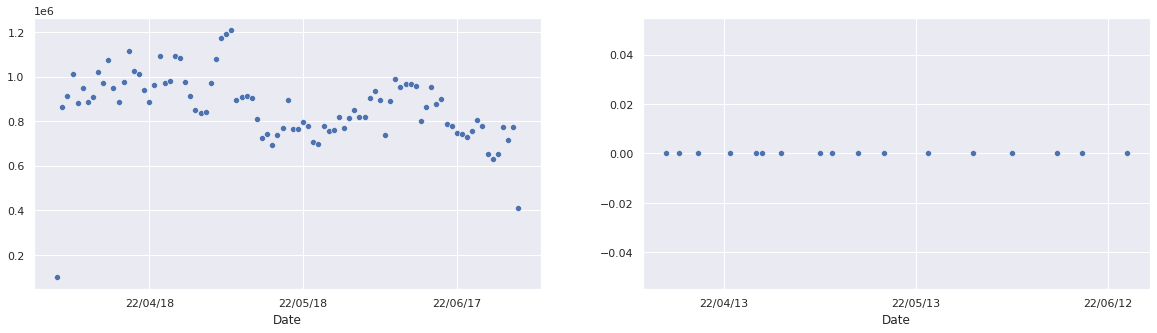

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,5)); axes.flatten()

sns.scatterplot(x = "Date", y = sum_ama_ama.values, data = sum_ama_ama, ax = axes[0])
sns.scatterplot(x = "Date", y =sum_ama_nonama.values, data = sum_ama_nonama, ax = axes[1])


for i in range(2):
  axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=30))
  axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))

In [ ]:
ama_sale["currency"].unique()

array(['INR', nan], dtype=object)

In [ ]:
ama_sale.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [ ]:
ama_sale.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [ ]:
ama_sale["Status"].unique()

array(['Cancelled', 'Shipped - Delivered to Buyer', 'Shipped',
       'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
       'Shipped - Lost in Transit', 'Shipped - Out for Delivery',
       'Shipped - Returning to Seller', 'Shipped - Picked Up', 'Pending',
       'Pending - Waiting for Pick Up', 'Shipped - Damaged', 'Shipping'],
      dtype=object)

## 상품 자체 정보 (배송, 품번, 종류)

In [ ]:
def describe_cat(df, cols):
  fig, axes = plt.subplots(1, len(cols), figsize=(20,5))


  for i in range(len(cols)):
    col_name = cols[i]
    print(df[col_name].unique())
    print(df[col_name].value_counts(), '\n')

    
    df[col_name].value_counts()[df[col_name].value_counts() >= 1000].plot(kind='bar', ax = axes[i])
  return 0

['Cancelled' 'Shipped - Delivered to Buyer' 'Shipped'
 'Shipped - Returned to Seller' 'Shipped - Rejected by Buyer'
 'Shipped - Lost in Transit' 'Shipped - Out for Delivery'
 'Shipped - Returning to Seller' 'Shipped - Picked Up' 'Pending'
 'Pending - Waiting for Pick Up' 'Shipped - Damaged' 'Shipping']
Shipped                          77804
Shipped - Delivered to Buyer     28769
Cancelled                        18332
Shipped - Returned to Seller      1953
Shipped - Picked Up                973
Pending                            658
Pending - Waiting for Pick Up      281
Shipped - Returning to Seller      145
Shipped - Out for Delivery          35
Shipped - Rejected by Buyer         11
Shipping                             8
Shipped - Lost in Transit            5
Shipped - Damaged                    1
Name: Status, dtype: int64 

['Standard' 'Expedited']
Expedited    88615
Standard     40360
Name: ship-service-level, dtype: int64 

['SET389' 'JNE3781' 'JNE3371' ... 'SET066' 'J0286' 'SET0

0

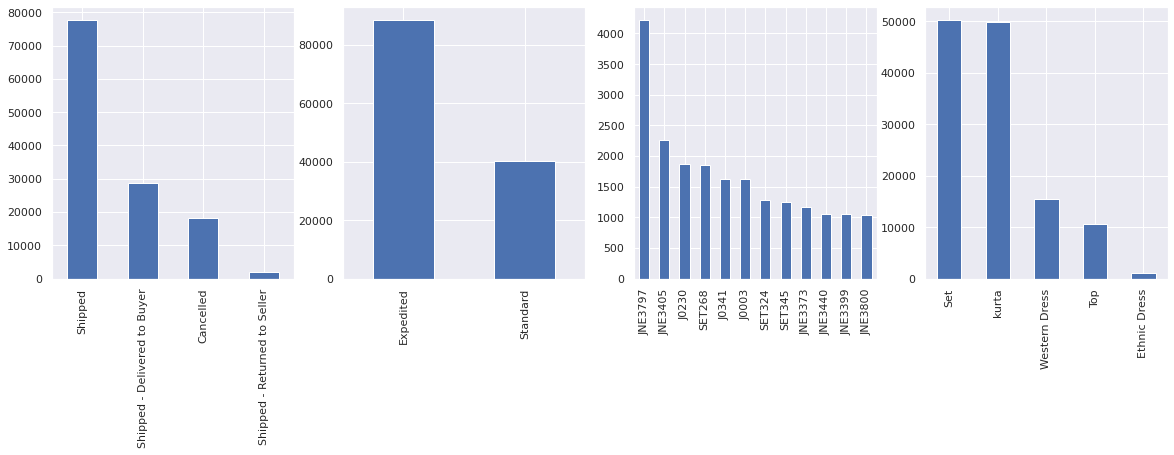

In [ ]:
ama_sale_obj_col = ['Status', 'ship-service-level', 'Style', 'Category']
describe_cat(ama_sale, ama_sale_obj_col)

이정도면 얘네만으로도 뭐 해볼 수 있을 것 같은데? ㅎㅎ <br>
이거 그냥 style_alphabet이랑 date를 엮을 수도 있을 것 같고, <br> 
alphabet에서 size로 이을 수도 있겠고, 생각해보니까 한 사람이 어떤 사이즈를 사는지 어떤 style alphabet을 사는지, 그런 거는 이미 user based에서 끝났으려나
status 에서 cancelled라면...? 왜 cancelled 되었는가를 알아야하고 어떤 것이 얼마나 cancel되었는지도 알아야해 그렇다면 

In [ ]:
ama_sale.insert(8, 'Style_Alphabet', 'a')
ama_sale['Style_Alphabet'] = ama_sale['Style'].str.extract(r'([A-Z]+)')
ama_sale.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,Style_Alphabet,SKU,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET,SET389-KR-NP-S,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE,JNE3781-KR-XXXL,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN


In [ ]:
ama_sale['Style_Alphabet'].unique()

array(['SET', 'JNE', 'J', 'PJNE', 'MEN', 'NW', 'BTM', 'PJ', 'SAR', 'BL',
       'CH', 'AN', 'PSET', 'DPT'], dtype=object)

In [ ]:
ama_sale.groupby("Style_Alphabet")["index"].count().sort_values()

Style_Alphabet
DPT         3
PJ         33
CH         36
AN         88
SAR       141
PSET      190
BTM       316
BL        451
PJNE     1492
NW       2317
MEN      4044
J       31116
SET     34570
JNE     54178
Name: index, dtype: int64

일단 Expedited가 뭐가 적고, Standard는 뭐가 많네<br>
그러면 각 항목 중에서 뭐가 좋은 거고 뭐가 나쁜 건지 생각을 해보고<br>
이걸 그냥 하나의 column으로 추가해버리자.<br>
기준은 거래가 성사되어 완료 되었는가, 취소되었는가, 진행 중인가 세가지?

In [ ]:
ama_sale.groupby(["ship-service-level", "Status"])["index"].count()

ship-service-level  Status                       
Expedited           Cancelled                        11423
                    Pending                            413
                    Shipped                          76779
Standard            Cancelled                         6909
                    Pending                            245
                    Pending - Waiting for Pick Up      281
                    Shipped                           1025
                    Shipped - Damaged                    1
                    Shipped - Delivered to Buyer     28769
                    Shipped - Lost in Transit            5
                    Shipped - Out for Delivery          35
                    Shipped - Picked Up                973
                    Shipped - Rejected by Buyer         11
                    Shipped - Returned to Seller      1953
                    Shipped - Returning to Seller      145
                    Shipping                             8
Name: 

In [ ]:
ama_sale.insert(4, 'Status_Cat', 'a')
ama_sale.loc[ama_sale["Status"].isin(["Shipped", "Shipped - Damaged", 'Shipped - Delivered to Buyer', "Shipped - Picked Up"]), "Status_Cat"] = "Shipped"
ama_sale.loc[ama_sale["Status"].isin(["Pending", "Pending - Waiting for Pick Up", "Shipped - Out for Delivery", "Shipped - Returning to Seller", "Shipping"]), "Status_Cat"] = "Pending"
ama_sale.loc[ama_sale["Status"].isin(["Cancelled", "Shipped - Lost in Transit", "Shipped - Rejected by Buyer", "Shipped - Returned to Seller"]), "Status_Cat"] = "Cancelled"
ama_sale.head(2)

,index,Order ID,Date,Status,Status_Cat,Fulfilment,Sales Channel,ship-service-level,Style,Style_Alphabet,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Cancelled,Merchant,Amazon.in,Standard,SET389,SET,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Shipped,Merchant,Amazon.in,Standard,JNE3781,JNE,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN


거래가 성사되지 않은 경우가 0.2 정도 되네 <br>
제품 카테고리 별로 성사되지 않는 비율을 확인해볼 필요가 있겠다<br>
일단 제품 카테고리 별 성사되지 않은 제품의 개수부터 찾아보자

In [ ]:
ama_sale.groupby("Status_Cat")["index"].count()

Status_Cat
Cancelled     20301
Pending        1127
Shipped      107547
Name: index, dtype: int64

BTM이라는 친구의 거래 미성사율이 가장 높네 <br>
반면 CH는 매우 적은 편에 속하고

In [ ]:
cancelled_style_prop = ama_sale[ama_sale["Status_Cat"] == "Cancelled"].groupby("Style_Alphabet")["index"].count() / ama_sale.groupby("Style_Alphabet")["index"].count()
cancelled_style_prop.sort_values()

Style_Alphabet
CH      0.027778
PJ      0.030303
PJNE    0.111260
AN      0.113636
NW      0.129478
PSET    0.136842
BL      0.144124
SAR     0.148936
J       0.150630
MEN     0.151088
SET     0.161759
JNE     0.161818
BTM     0.170886
DPT          NaN
Name: index, dtype: float64

<AxesSubplot:xlabel='Style_Alphabet'>

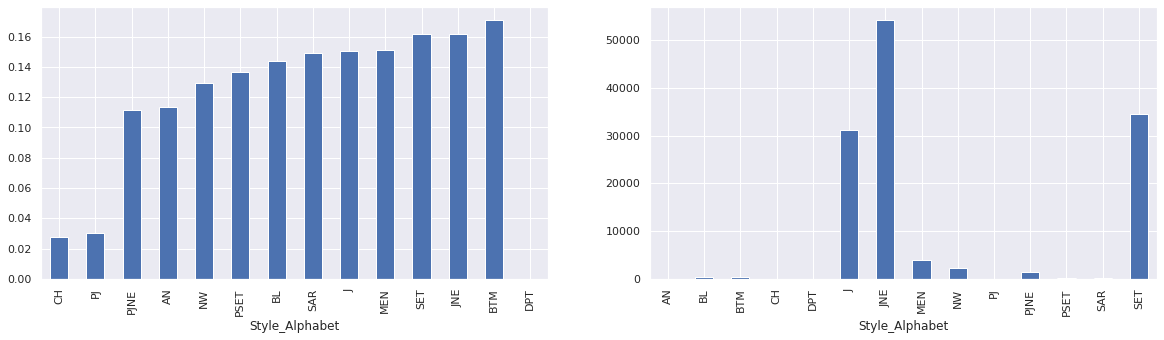

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

cancelled_style_prop.sort_values().plot(kind='bar', ax = axes[0])
ama_sale.groupby("Style_Alphabet")["index"].count().plot(kind = 'bar', ax = axes[1])

AN부터는 비율 값들을 믿어도 될 것 같아<br>
보통 표본 추출을 하면 n > 30 라는 조건이 붙으니까 넉넉잡아 AN부터 쓰자

In [ ]:
enough_style_alphabet = ama_sale.groupby("Style_Alphabet")["index"].count()[ama_sale.groupby("Style_Alphabet")["index"].count() >= 80]
enough_style_alphabet.index

Index(['AN', 'BL', 'BTM', 'J', 'JNE', 'MEN', 'NW', 'PJNE', 'PSET', 'SAR',
       'SET'],
      dtype='object', name='Style_Alphabet')

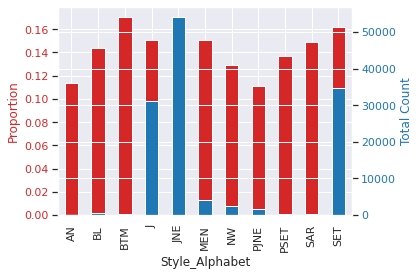

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Style_Alphabet')
ax1.set_ylabel('Proportion', color=color)
cancelled_style_prop[enough_style_alphabet.index].plot(kind='bar', color=color, ax = ax1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total Count', color=color)  # we already handled the x-label with ax1
ama_sale.groupby("Style_Alphabet")["index"].count()[enough_style_alphabet.index].plot(kind = 'bar', color=color, ax = ax2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

위 그림보다는 아래가 나을 듯<br>
일단 아래에서 얻을 수 있는 거는 표본 수가 많은 것 중 JNE랑 SET가 높고 J는 약간 낮은 편에 속한다  

<AxesSubplot:xlabel='Style_Alphabet'>

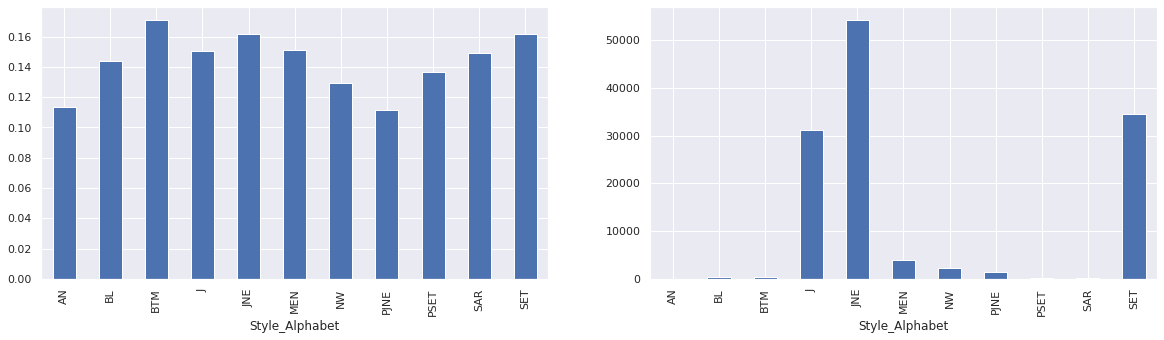

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

cancelled_style_prop.sort_values()[enough_style_alphabet.index].plot(kind='bar', ax = axes[0])
ama_sale.groupby("Style_Alphabet")["index"].count()[enough_style_alphabet.index].plot(kind = 'bar', ax = axes[1])

# Cloud Warehouse Compersion Chart Data Load

#### data description
- inbound: 창고로 들어온다(?)
- outbound: 창고에서 나간다(?)


In [ ]:
cloud_warehouse = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Dataset/amazon/Cloud Warehouse Compersion Chart.csv")
cloud_warehouse.head()

,index,Shiprocket,Unnamed: 1,INCREFF
0,0,Heads,Price (Per Unit),Price (Per Unit)
1,1,Inbound (Fresh Stock and RTO),₹4.00,4
2,2,Outbound,₹7.00,11
3,3,Storage Fee/Cft,₹25.00,Rs 0.15/- Per Day
4,4,Customer Return with Detailed QC,₹6.00,15.5


# Expense IIGF Data Load

In [ ]:
expense = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Dataset/amazon/Expense IIGF.csv", index_col = 0)
expense.head()

,Recived Amount,Unnamed: 1,Expance,Unnamed: 3
index,,,,
0,Particular,Amount,Particular,Amount
1,06-19-22,1000,Large Bag,380
2,06-20-22,1500,"Stationary(Soft Pin, Paper pin for Dupatta, Fe...",170
3,06-22-22,500,OLA,839
4,06-23-22,2000,Auto Rent,520


In [ ]:
expense.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Recived Amount  6 non-null      object
 1   Unnamed: 1      6 non-null      object
 2   Expance         15 non-null     object
 3   Unnamed: 3      17 non-null     object
dtypes: object(4)
memory usage: 680.0+ bytes


In [ ]:
expense

,Recived Amount,Unnamed: 1,Expance,Unnamed: 3
index,,,,
0,Particular,Amount,Particular,Amount
1,06-19-22,1000,Large Bag,380
2,06-20-22,1500,"Stationary(Soft Pin, Paper pin for Dupatta, Fe...",170
3,06-22-22,500,OLA,839
4,06-23-22,2000,Auto Rent,520
5,NaN,NaN,TT Fine,500
6,NaN,NaN,Bhushan Hotel,2506
7,NaN,NaN,Food,1290
8,NaN,NaN,Expomart Labour Charge,200


# International sale Report data의 costumer 기준으로 extract insight
- user based recommendation complete

## 기본적인 international data의 전처리


In [ ]:
international = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Dataset/amazon/International sale Report.csv")
international.head()

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.00,616.56,617.00
1,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.00,616.56,617.00
2,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.00,616.56,617.00
3,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.00,616.56,617.00
4,4,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.00,616.56,617.00


In [ ]:
international.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37432 entries, 0 to 37431
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      37432 non-null  int64 
 1   DATE       37431 non-null  object
 2   Months     37407 non-null  object
 3   CUSTOMER   36392 non-null  object
 4   Style      36392 non-null  object
 5   SKU        34958 non-null  object
 6   Size       36392 non-null  object
 7   PCS        36392 non-null  object
 8   RATE       36392 non-null  object
 9   GROSS AMT  36392 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.9+ MB


### RATE에 GROSS AMT라는 값이 존재해서 float 으로 한번에 변경할 수가 없다.

In [ ]:
international[international['RATE'] == 'GROSS AMT']

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
19675,19675,CUSTOMER,DATE,Months,Style,SKU,PCS,RATE,GROSS AMT,Stock


In [ ]:
international.iloc[19675, :]

index            19675
DATE          CUSTOMER
Months            DATE
CUSTOMER        Months
Style            Style
SKU                SKU
Size               PCS
PCS               RATE
RATE         GROSS AMT
GROSS AMT        Stock
Name: 19675, dtype: object

#### 19675 행만 처리하면 될 줄 알았으나 그 외의 row도 엉망이다

In [ ]:
new_inter = international.iloc[:19675, :]

In [ ]:
sum(new_inter.isna()["SKU"])

2457

#### 엉망인 row 전부 삭제

In [ ]:
new_inter = new_inter[-new_inter.isna()["SKU"]]
new_inter

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.00,616.56,617.00
1,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.00,616.56,617.00
2,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.00,616.56,617.00
3,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.00,616.56,617.00
4,4,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.00,616.56,617.00
...,...,...,...,...,...,...,...,...,...,...
17230,17230,03-31-22,Mar-22,AVIN,SET276,SET276-KR-PP-L,L,1.00,1425.00,1425.00
17231,17231,03-31-22,Mar-22,AVIN,PJNE3423,PJNE3423-KR-4XL,4XL,1.00,537.50,538.00
17232,17232,03-31-22,Mar-22,AVIN,PJNE3404,PJNE3404-KR-4XL,4XL,1.00,500.00,500.00
17233,17233,03-31-22,Mar-22,AVIN,PJNE3423,PJNE3423-KR-4XL,4XL,1.00,537.50,538.00


In [ ]:
new_inter.isna().sum()

index        0
DATE         0
Months       0
CUSTOMER     0
Style        0
SKU          0
Size         0
PCS          0
RATE         0
GROSS AMT    0
dtype: int64

In [ ]:
sum(new_inter['RATE'] == "GROSS AMT")

0

In [ ]:
new_inter['RATE'].astype(float)

0         616.56
1         616.56
2         616.56
3         616.56
4         616.56
          ...   
17230    1425.00
17231     537.50
17232     500.00
17233     537.50
17234     812.50
Name: RATE, Length: 17218, dtype: float64

In [ ]:
international = new_inter.astype({"PCS": "float", "RATE": "float", "GROSS AMT": "float"})
international

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.0,616.56,617.0
1,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.0,616.56,617.0
2,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.0,616.56,617.0
3,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.0,616.56,617.0
4,4,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.0,616.56,617.0
...,...,...,...,...,...,...,...,...,...,...
17230,17230,03-31-22,Mar-22,AVIN,SET276,SET276-KR-PP-L,L,1.0,1425.00,1425.0
17231,17231,03-31-22,Mar-22,AVIN,PJNE3423,PJNE3423-KR-4XL,4XL,1.0,537.50,538.0
17232,17232,03-31-22,Mar-22,AVIN,PJNE3404,PJNE3404-KR-4XL,4XL,1.0,500.00,500.0
17233,17233,03-31-22,Mar-22,AVIN,PJNE3423,PJNE3423-KR-4XL,4XL,1.0,537.50,538.0


In [ ]:
international.groupby("CUSTOMER")["GROSS AMT"].sum()

CUSTOMER
AANCHOL                              11452.0
ABBI COLLECTION                      37114.0
ABDUL RAHMAN(SINGAPORE)              48106.0
ADDVEN SOLUTIONS PRIVATE LIMITED     32228.0
AKASH KAUSHAL                         5580.0
                                      ...   
VISHA DEVAN                         321028.0
VISHAL DARSHAN BOUTIQUE             316277.0
YAMUNAH PUSPANATHAN                  17899.0
YASHWINI REDDY                       26950.0
YASSHLINY KUNJU                      90972.0
Name: GROSS AMT, Length: 125, dtype: float64

## User based recommendation system:
 - CUSTOMER의 공통점을 찾을 수 있을 것인가?
 - 날짜별로 구분지을 때 사용자 혹은 제품의 판매 양상을 찾을 수 있을 것인가?
 - ama_sale 데이터와 연관 지으면 어느 정도 사용자 매칭이 가능할 수도 있는데 이거 이용해볼 수 있을까? 

In [ ]:
ama_sale[ama_sale['Style'] == "MEN5004"]

,index,Order ID,Date,Status,Status_Cat,Fulfilment,Sales Channel,ship-service-level,Style,Style_Alphabet,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
174,174,406-3078054-1755513,2022-04-30,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,484.00,BIJNOR,UTTAR PRADESH,246722.0,IN,NaN,False,NaN,NaN
221,221,403-5209693-1173944,2022-04-30,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,484.00,GREATER NOIDA,UTTAR PRADESH,201308.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN
947,947,408-8489677-5577933,2022-04-30,Shipped - Delivered to Buyer,Shipped,Merchant,Amazon.in,Standard,MEN5004,MEN,...,INR,0.00,NOIDA,UTTAR PRADESH,201304.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2653,2653,406-7455558-9750768,2022-04-29,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,484.00,MUMBAI,MAHARASHTRA,400071.0,IN,NaN,False,NaN,NaN
2801,2801,407-2411763-9743510,2022-04-29,Cancelled,Cancelled,Merchant,Amazon.in,Standard,MEN5004,MEN,...,INR,460.95,BENGALURU,KARNATAKA,560048.0,IN,NaN,False,Easy Ship,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127356,127356,406-4182404-7620304,2022-06-02,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,698.00,NEW TOWN,WEST BENGAL,700136.0,IN,NaN,False,NaN,False
128557,128557,406-3274616-2702732,2022-06-01,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,698.00,KHAGARIA,BIHAR,851205.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,False
128562,128562,403-2604839-1760360,2022-06-01,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,698.00,NEW DELHI,DELHI,110091.0,IN,NaN,False,NaN,False
128838,128838,402-3140751-2277925,2022-06-01,Shipped,Shipped,Amazon,Amazon.in,Expedited,MEN5004,MEN,...,INR,709.00,Ahmedabad,Gujarat,380015.0,IN,NaN,False,NaN,False


In [ ]:
ama_sale[ama_sale['Style'] == "MEN5004"].groupby("Order ID")['Amount'].sum()

Order ID
171-0218523-4828331    484.0
171-0328262-0233953    698.0
171-1220730-9645138    480.0
171-1310111-5042701    709.0
171-1446836-2525169      0.0
                       ...  
408-9823411-1542758    709.0
408-9921065-7263501      0.0
408-9962434-0281134    484.0
408-9972732-0523541      0.0
S02-8541050-2963857      0.0
Name: Amount, Length: 373, dtype: float64

In [ ]:
sum(ama_sale['Style'] == "MEN5004")

373

### sku_code data와 international data를 병합하자

In [ ]:
sku_code = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Dataset/amazon/Sale Report.csv")
sku_code.head()

,index,SKU Code,Design No.,Stock,Category,Size,Color
0,0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red
1,1,AN201-RED-M,AN201,5.0,AN : LEGGINGS,M,Red
2,2,AN201-RED-S,AN201,3.0,AN : LEGGINGS,S,Red
3,3,AN201-RED-XL,AN201,6.0,AN : LEGGINGS,XL,Red
4,4,AN201-RED-XXL,AN201,3.0,AN : LEGGINGS,XXL,Red


In [ ]:
international.head()

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.0,616.56,617.0
1,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.0,616.56,617.0
2,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.0,616.56,617.0
3,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.0,616.56,617.0
4,4,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5011,MEN5011-KR-L,L,1.0,616.56,617.0


In [ ]:
sku_code.head()

,index,SKU Code,Design No.,Stock,Category,Size,Color
0,0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red
1,1,AN201-RED-M,AN201,5.0,AN : LEGGINGS,M,Red
2,2,AN201-RED-S,AN201,3.0,AN : LEGGINGS,S,Red
3,3,AN201-RED-XL,AN201,6.0,AN : LEGGINGS,XL,Red
4,4,AN201-RED-XXL,AN201,3.0,AN : LEGGINGS,XXL,Red


### sku_code 데이터도 NAN 처리

In [ ]:
sku_code.isna().sum(axis = 0)

index          0
SKU Code      83
Design No.    36
Stock         36
Category      45
Size          36
Color         45
dtype: int64

In [ ]:
sku_code = sku_code[-sku_code.isna()["SKU Code"]]
sku_code.isna().sum(axis = 0)

index         0
SKU Code      0
Design No.    0
Stock         0
Category      0
Size          0
Color         0
dtype: int64

### international과 sale 데이터에서 sku 기준으로 병합
 - 기본 출처: https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4
 - 텐서 응용: https://medium.com/geekculture/get-started-with-tensorflow-recommenders-and-matrix-factorization-a90abae852e1

In [ ]:
# international과 sku_code에서 SKU 기준으로 병합할 건데 둘 모두 index size를 갖고 있으므로 sku_code에서 삭제 
sku_code.drop(columns=['Size', 'index'], inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
sku_code.head(0)

,SKU Code,Design No.,Stock,Category,Color


In [ ]:
# 겹치는게 얼마나 있나 확인해 보자
unique_inter = international.SKU.unique()
unique_sku = sku_code["SKU Code"].unique()

print('-'*10, "international", '-'*10)
print(unique_inter)
print(len(unique_inter), end = '\n\n\n')

print('-'*10, "sku code", '-'*10)
print(unique_sku)
print(len(unique_sku), end = '\n')

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 
# Driver Code
intersect = intersection(unique_inter, unique_sku)
print(intersect)
print(len(intersect))

---------- international ----------
['MEN5004-KR-L' 'MEN5004-KR-XL' 'MEN5004-KR-XXL' ... 'JNE3786-KR-XXXL'
 'SET356-KR-NP-M' 'PJNE3404-KR-4XL']
4590


---------- sku code ----------
['AN201-RED-L' 'AN201-RED-M' 'AN201-RED-S' ... 'SET462-KR-NP-XS'
 'SET462-KR-NP-XXL' 'SET462-KR-NP-XXXL']
9170
['SET290-KR-DPT-XXL', 'SET188-KR-NP-XXXL', 'JNE3767-KR-S', 'JNE3440-KR-XXXL', 'SET275-KR-NP-XL', 'JNE3684-TU-S', 'JNE3555-KR-XXXL', 'SET144-KR-NP-M', 'JNE3678-TU-XS', 'J0117-TP-L', 'NW030-TP-PJ-S', 'NW031-TP-PJ-S', 'JNE3665-TP-XXL', 'J0244-SKD-XXL', 'J0189-TP-XXL', 'J0278-SET-XXL', 'SET182-KR-DH-XXL', 'JNE3669-TU-M', 'J0113-TP-XXXL', 'JNE3771-KR-M', 'JNE3675-TU-L', 'J0296-DR-L', 'SET413-KR-NP-L', 'JNE3408-KR-XXXL', 'JNE3567-KR-S', 'SET276-KR-PP-XXXL', 'SET333-KR-DPT-L', 'JNE3273-KR-M', 'SET291-KR-PP-XXXL', 'JNE3686-TU-XXXL', 'JNE3719-KR-XXXL', 'JNE3432-KR-XXL', 'JNE3870-DR-S', 'JNE3454-KR-XS', 'JNE3753-KR-L', 'SET245-KR-NP-L', 'J0012-SKD-S', 'J0203-TP-XS', 'JNE3443-KR-XL', 'JNE3606-KR-L', 'J0283-SE

In [ ]:
sku_code.rename(columns = {'SKU Code' : 'SKU'}, inplace = True)

inter_sku = pd.merge(international, sku_code, on='SKU', how='inner')
print(inter_sku.shape)
inter_sku.head() # merge 결과 SKU를 기준으로 정렬이 된다.

(16848, 14)


,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT,Design No.,Stock,Category,Color
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.0,616.56,617.0,MEN5004,5.0,KURTA,Blue
1,5307,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.00,586.0,MEN5004,5.0,KURTA,Blue
2,5313,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.00,586.0,MEN5004,5.0,KURTA,Blue
3,5316,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.00,586.0,MEN5004,5.0,KURTA,Blue
4,11003,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.00,586.0,MEN5004,5.0,KURTA,Blue


In [ ]:
# gross amt랑 rate는 뭔 차이일까

diff_rate_amt = inter_sku.RATE - inter_sku["GROSS AMT"]
diff_rate_amt[diff_rate_amt != 0]

0          -0.44
7          -0.44
12         -0.44
14       -586.00
15       -586.00
          ...   
16834      11.00
16842       0.25
16843      -0.50
16844      -0.50
16845   -1275.00
Length: 11015, dtype: float64

In [ ]:
# 둘이 같지않은게 생각보다 많다
# 어떤 거는 RATE가 0이네 -> 그럼 GROSS AMT를 이용해버리자
inter_sku.drop(columns=['RATE'], inplace = True)
inter_sku.head(0)

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,GROSS AMT,Design No.,Stock,Category,Color


In [ ]:
inter_sku.head()

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,GROSS AMT,Design No.,Stock,Category,Color
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.0,617.0,MEN5004,5.0,KURTA,Blue
1,5307,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.0,MEN5004,5.0,KURTA,Blue
2,5313,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.0,MEN5004,5.0,KURTA,Blue
3,5316,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.0,MEN5004,5.0,KURTA,Blue
4,11003,10-11-21,Oct-21,DHENOOGA RAVINTHERAN,MEN5004,MEN5004-KR-L,L,1.0,586.0,MEN5004,5.0,KURTA,Blue


### 집계

In [ ]:
# Aggregate by CUSTOMER
agg_cus = inter_sku.groupby('CUSTOMER').agg(number_of_purchase = ('GROSS AMT', 'count'),
                                                number_of_pcs = ("PCS", "sum"),
                                                sum_of_amount = ("GROSS AMT", "sum"))
print(agg_cus.shape)
agg_cus.head()

(123, 3)


,number_of_purchase,number_of_pcs,sum_of_amount
CUSTOMER,,,
AANCHOL,4,18.0,11452.0
ABBI COLLECTION,70,70.0,37114.0
ABDUL RAHMAN(SINGAPORE),96,96.0,48106.0
ADDVEN SOLUTIONS PRIVATE LIMITED,46,46.0,32228.0
AKASH KAUSHAL,10,10.0,5580.0


In [ ]:
# Keep the CUSTOMER with over 10 purchase
# 우수 고객 찾기? 
agg_purchase_GT = agg_cus[agg_cus['number_of_purchase']>10]
print(agg_purchase_GT.shape)
agg_purchase_GT.head()

(115, 3)


,number_of_purchase,number_of_pcs,sum_of_amount
CUSTOMER,,,
ABBI COLLECTION,70,70.0,37114.0
ABDUL RAHMAN(SINGAPORE),96,96.0,48106.0
ADDVEN SOLUTIONS PRIVATE LIMITED,46,46.0,32228.0
ALAMELOO(MALA),94,100.0,65941.0
AMANI CONCEPT TRADING LLC (KAPDA),338,1829.0,922603.0


In [ ]:
# Check
agg_purchase_GT.sort_values(by='sum_of_amount', ascending=False).head()

,number_of_purchase,number_of_pcs,sum_of_amount
CUSTOMER,,,
MULBERRIES BOUTIQUE,1825,1866.0,1685080.0
AMANI CONCEPT TRADING LLC (KAPDA),338,1829.0,922603.0
VAHARSHA BOUTIQUE,576,614.0,440264.0
GALAXY GROUP OF COMPANIES PVT. LTD,448,620.0,440038.0
RIVAAN LLC,499,656.0,436000.0


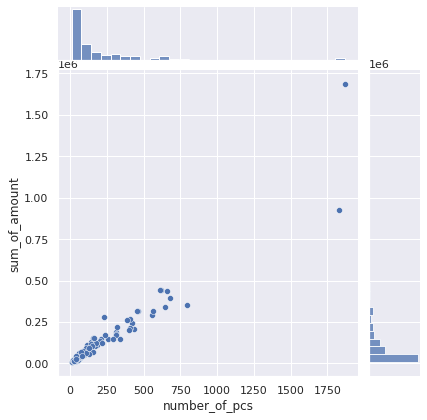

In [ ]:
# Visulization
sns.jointplot(x='number_of_pcs', y='sum_of_amount', data=agg_purchase_GT)

In [ ]:
# 위에서 찾은 구매 10회 이상 customer에 대해서만 Merge data 
inter_sku_GT = pd.merge(inter_sku, pd.DataFrame(agg_purchase_GT.index), on='CUSTOMER', how='inner')
print(inter_sku.shape)
inter_sku_GT.info()

(16848, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16776 entries, 0 to 16775
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16776 non-null  int64  
 1   DATE        16776 non-null  object 
 2   Months      16776 non-null  object 
 3   CUSTOMER    16776 non-null  object 
 4   Style       16776 non-null  object 
 5   SKU         16776 non-null  object 
 6   Size        16776 non-null  object 
 7   PCS         16776 non-null  float64
 8   GROSS AMT   16776 non-null  float64
 9   Design No.  16776 non-null  object 
 10  Stock       16776 non-null  float64
 11  Category    16776 non-null  object 
 12  Color       16776 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 1.8+ MB


In [ ]:
inter_sku_GT.head()

,index,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,GROSS AMT,Design No.,Stock,Category,Color
0,0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.0,617.0,MEN5004,5.0,KURTA,Blue
1,1,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XL,XL,1.0,617.0,MEN5004,11.0,KURTA,Blue
2,2,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-XXL,XXL,1.0,617.0,MEN5004,3.0,KURTA,Blue
3,3,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.0,617.0,MEN5009,12.0,KURTA,Maroon
4,5029,10-06-21,Oct-21,REVATHY LOGANATHAN,MEN5009,MEN5009-KR-L,L,1.0,549.0,MEN5009,12.0,KURTA,Maroon


In [ ]:
# Number of users
print('The ratings dataset has', inter_sku_GT['CUSTOMER'].nunique(), 'unique CUSTOMER')
# Number of movies
print('The ratings dataset has', inter_sku_GT['SKU'].nunique(), 'unique SKU')

The ratings dataset has 115 unique CUSTOMER
The ratings dataset has 4474 unique SKU


### similarity 계산

In [ ]:
# Create user-item matrix
# 결과는 당연히 NaN이 많을 수 밖에 없다
# 한 customer가 구매하는 제품의 수는 그리 많지 않기 때문
matrix = inter_sku_GT.pivot_table(index='CUSTOMER', columns='SKU', values='GROSS AMT')
matrix.head()

SKU,AN202-ORANGE-L,AN202-ORANGE-M,AN202-ORANGE-S,AN202-ORANGE-XL,AN202-ORANGE-XXL,AN205-YELLOW-L,AN205-YELLOW-M,AN205-YELLOW-S,AN209-BIEGE-XXL,BL009-61BLACK,...,SET409-KR-NP-XL,SET409-KR-NP-XS,SET409-KR-NP-XXL,SET413-KR-NP-L,SET413-KR-NP-M,SET413-KR-NP-S,SET413-KR-NP-XL,SET413-KR-NP-XS,SET413-KR-NP-XXL,SET413-KR-NP-XXXL
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
ABBI COLLECTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABDUL RAHMAN(SINGAPORE),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDVEN SOLUTIONS PRIVATE LIMITED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALAMELOO(MALA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMANI CONCEPT TRADING LLC (KAPDA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

SKU,AN202-ORANGE-L,AN202-ORANGE-M,AN202-ORANGE-S,AN202-ORANGE-XL,AN202-ORANGE-XXL,AN205-YELLOW-L,AN205-YELLOW-M,AN205-YELLOW-S,AN209-BIEGE-XXL,BL009-61BLACK,...,SET409-KR-NP-XL,SET409-KR-NP-XS,SET409-KR-NP-XXL,SET413-KR-NP-L,SET413-KR-NP-M,SET413-KR-NP-S,SET413-KR-NP-XL,SET413-KR-NP-XS,SET413-KR-NP-XXL,SET413-KR-NP-XXXL
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
ABBI COLLECTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABDUL RAHMAN(SINGAPORE),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDVEN SOLUTIONS PRIVATE LIMITED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALAMELOO(MALA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMANI CONCEPT TRADING LLC (KAPDA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

CUSTOMER,ABBI COLLECTION,ABDUL RAHMAN(SINGAPORE),ADDVEN SOLUTIONS PRIVATE LIMITED,ALAMELOO(MALA),AMANI CONCEPT TRADING LLC (KAPDA),AMBIKA SYAM SUNDAR,ANJU BHARATI,ANU RANJANI ANPALAGAN,ARANGAN FASHIONS,ARKH FASHION,...,VENDAN,VIKNES THREADS COLLECTION,VINI’S AUTHENTIC INDIAN ETHNIC WEAR,VINODHA PUSPANATHAN,VINTAGE INDIA NYC,VISHA DEVAN,VISHAL DARSHAN BOUTIQUE,YAMUNAH PUSPANATHAN,YASHWINI REDDY,YASSHLINY KUNJU
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
ABBI COLLECTION,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABDUL RAHMAN(SINGAPORE),NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDVEN SOLUTIONS PRIVATE LIMITED,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
ALAMELOO(MALA),NaN,NaN,NaN,1.000000,0.935574,0.999171,0.999963,NaN,NaN,NaN,...,0.5,NaN,NaN,NaN,NaN,NaN,0.999977,NaN,NaN,NaN
AMANI CONCEPT TRADING LLC (KAPDA),1.0,NaN,NaN,0.935574,1.000000,-0.389790,0.850543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.432686,NaN,-1.000000,NaN,1.0,NaN


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.02347248,  0.        , ...,  0.04439185,
         0.        ,  0.        ],
       [ 0.02347248,  1.        ,  0.        , ...,  0.        ,
         0.        , -0.02562883],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.03255572,  0.        ],
       ...,
       [ 0.04439185,  0.        ,  0.        , ...,  1.        ,
         0.03398014,  0.        ],
       [ 0.        ,  0.        ,  0.03255572, ...,  0.03398014,
         1.        ,  0.        ],
       [ 0.        , -0.02562883,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
# Remove picked user ID from the candidate list
# 가장 처음 userid 가 1이라 약속
picked_userid = 1
user_similarity_picked = user_similarity.iloc[picked_userid: , :picked_userid].fillna(0)

# Number of similar users
n = 20
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = pd.DataFrame(user_similarity_picked[(user_similarity_picked> 0.3).values])
similar_users = similar_users.sort_values(by = similar_users.columns[0], ascending = False)[:n]
similar_users

CUSTOMER,ABBI COLLECTION
CUSTOMER,
RIVAAN LLC,1.000000
AMANI CONCEPT TRADING LLC (KAPDA),1.000000
KALAIVANI PERMALU,1.000000
NIRUSAH TAILORING,1.000000
MR.JEYARAJ,1.000000
MEERA RASADURAI,1.000000
KAVEENAZ COLLECTION,1.000000
MALLAR MAHALINGAM,1.000000
MULBERRIES BOUTIQUE,0.997527


### user based recommendation system 구축
 - 이미 구매한 상품 배제
 - similar user의 상품 추천

In [ ]:
picked_userid_bought = matrix_norm.iloc[:1, :].dropna(axis=1, how='all')
picked_userid_bought 

SKU,J0005-DR-XXL,J0120-TP-XXL,J0249-SKD-XXL,J0252-SKD-XXXL,JNE3405-KR-M,JNE3420-KR-L,JNE3420-KR-XXL,JNE3434-KR-L,JNE3434-KR-XXL,JNE3435-KR-L,...,JNE3627-KR-XXXL,JNE3718-KR-XXL,JNE3718-KR-XXXL,JNE3802-KR-XXXL,JNE3805-KR-XL,SET038-KR-PP-L,SET038-KR-PP-XXXL,SET182-KR-DH-M,SET182-KR-DH-XXL,SET187-KR-DH-L
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
ABBI COLLECTION,394.8,-142.2,507.8,507.8,-140.2,-140.2,-140.2,-105.2,-105.2,-140.2,...,-91.2,-5.2,-5.2,-105.2,-105.2,244.8,244.8,281.8,281.8,244.8


In [ ]:
# 비슷한 유저가 구매한 상품을 가져오고 nan 처리
similar_user_items = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_items

SKU,AN202-ORANGE-L,AN202-ORANGE-M,AN202-ORANGE-S,AN202-ORANGE-XL,AN202-ORANGE-XXL,AN205-YELLOW-L,AN205-YELLOW-M,AN205-YELLOW-S,AN209-BIEGE-XXL,BL009-61BLACK,...,SET409-KR-NP-XL,SET409-KR-NP-XS,SET409-KR-NP-XXL,SET413-KR-NP-L,SET413-KR-NP-M,SET413-KR-NP-S,SET413-KR-NP-XL,SET413-KR-NP-XS,SET413-KR-NP-XXL,SET413-KR-NP-XXXL
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
AMANI CONCEPT TRADING LLC (KAPDA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BHANU SALEINE NAUNITHAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COTTON CLOSET LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DHENOOGA RAVINTHERAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FUSION FASHIONS CORP.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-391.732201,-164.732201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GALAXY GROUP OF COMPANIES PVT. LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IBRAHIM MAFTHOOH(JANASYA.IN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JEVI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KALAIVANI PERMALU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# target 유저가 구매한 상품 drop
similar_user_items.drop(picked_userid_bought.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_items

SKU,AN202-ORANGE-L,AN202-ORANGE-M,AN202-ORANGE-S,AN202-ORANGE-XL,AN202-ORANGE-XXL,AN205-YELLOW-L,AN205-YELLOW-M,AN205-YELLOW-S,AN209-BIEGE-XXL,BL009-61BLACK,...,SET409-KR-NP-XL,SET409-KR-NP-XS,SET409-KR-NP-XXL,SET413-KR-NP-L,SET413-KR-NP-M,SET413-KR-NP-S,SET413-KR-NP-XL,SET413-KR-NP-XS,SET413-KR-NP-XXL,SET413-KR-NP-XXXL
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
AMANI CONCEPT TRADING LLC (KAPDA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BHANU SALEINE NAUNITHAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COTTON CLOSET LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DHENOOGA RAVINTHERAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FUSION FASHIONS CORP.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-391.732201,-164.732201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GALAXY GROUP OF COMPANIES PVT. LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IBRAHIM MAFTHOOH(JANASYA.IN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JEVI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KALAIVANI PERMALU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
i = similar_user_items.columns[0]
items_rating = similar_user_items.loc[:, i]
items_rating

CUSTOMER
AMANI CONCEPT TRADING LLC (KAPDA)            NaN
BHANU SALEINE NAUNITHAM                      NaN
COTTON CLOSET LTD                            NaN
DHENOOGA RAVINTHERAN                         NaN
FUSION FASHIONS CORP.                        NaN
GALAXY GROUP OF COMPANIES PVT. LTD           NaN
IBRAHIM MAFTHOOH(JANASYA.IN)                 NaN
JEVI                                         NaN
KALAIVANI PERMALU                            NaN
KAVEENAZ COLLECTION                          NaN
MALLAR MAHALINGAM                            NaN
MEERA RASADURAI                              NaN
MOHANA KARTHIK                               NaN
MR.JEYARAJ                                   NaN
MULBERRIES BOUTIQUE                  -585.233378
NIRUSAH TAILORING                            NaN
RIVAAN LLC                                   NaN
SHILPI KUMARI                                NaN
VAHARSHA BOUTIQUE                            NaN
VAHARSHA BOUTIQUE                            NaN
Name: AN202

#### user based recommendation system complete

In [ ]:
# item score 저장 dictionary
item_score = {}
# Loop through items
for i in similar_user_items.columns:
  # i번째 item의 amount list들을 가져온다
  items_rating = similar_user_items[i]
  # Create variables to store the score and the number of scores
  total = 0
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If simliar user bought the item, which means the present amount value exsit
    if pd.isna(items_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users.loc[u,:].values * items_rating[u]
      # 누적 및 count for mean
      total += score
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['items', 'items_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='items_score', ascending=False)
ranked_item_score['items_score'] = ranked_item_score['items_score'].apply(float)

# Select top m movies
m = 10
ranked_item_score.head(m)

,items,items_score
765,J0239-SKD-XL,2299.864362
2669,SET267-KR-NP-XXXL,1922.999163
2668,SET267-KR-NP-XXL,1922.999163
840,J0284-SKD-M,1831.725166
842,J0284-SKD-XL,1830.062621
202,J0008-SKD-S,1809.491061
814,J0277-SKD-L,1766.387431
816,J0277-SKD-S,1766.387431
815,J0277-SKD-M,1766.387431
818,J0277-SKD-XXL,1765.888668


# Item과 Date의 관계

In [ ]:
ama_sale.head(3)

,index,Order ID,Date,Status,Status_Cat,Fulfilment,Sales Channel,ship-service-level,Style,Style_Alphabet,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Cancelled,Merchant,Amazon.in,Standard,SET389,SET,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Shipped,Merchant,Amazon.in,Standard,JNE3781,JNE,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


Text(0, 0.5, 'count of sale')

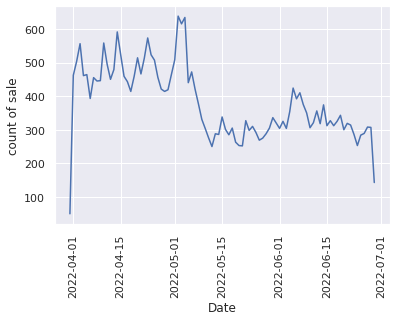

In [ ]:
ama_set_count = ama_sale[ama_sale["Style_Alphabet"] == 'SET'].groupby("Date")["index"].count()
plt.plot(ama_set_count)
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("count of sale")

날짜에 따른 각 제품들의 판매량 비교

Text(0, 0.5, 'count of sale')

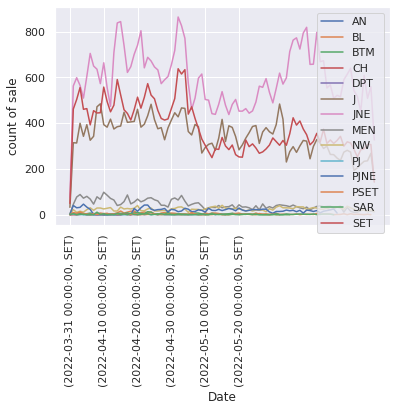

In [ ]:
k = ama_sale.groupby(["Date", "Style_Alphabet"])["index"].count()
k = pd.DataFrame(k)
k.groupby("Style_Alphabet")["index"].plot(legend = True)
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("count of sale")

fulfiliment에 따른 판매량과 날짜에 따른 각 제품들의 판매량 비교

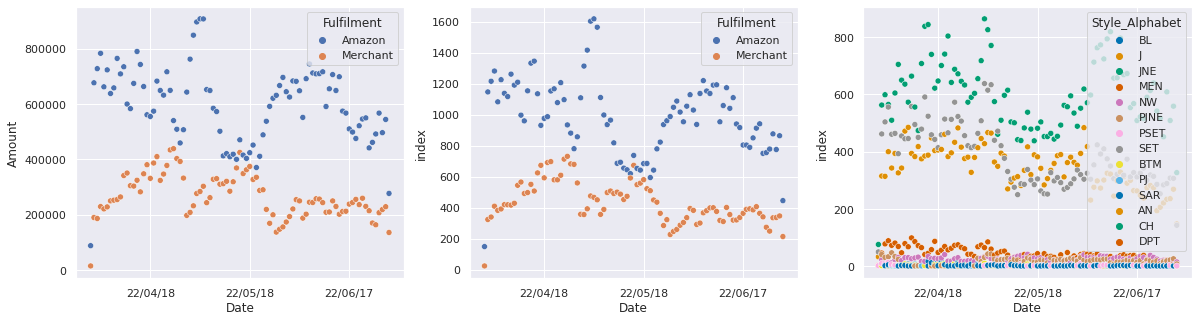

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

sum_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["Amount"].sum().to_frame().reset_index(level = "Fulfilment")
count_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["index"].count().to_frame().reset_index(level = "Fulfilment")
k = ama_sale.groupby(["Date", "Style_Alphabet"])["index"].count().to_frame().reset_index(level = "Style_Alphabet")


sns.scatterplot(x = "Date", y = 'Amount', data = sum_ama_fulfil_sale, hue = "Fulfilment", ax = axes[0])
sns.scatterplot(x = "Date", y = 'index', data = count_ama_fulfil_sale, hue = "Fulfilment", ax = axes[1])
sns.scatterplot(x = "Date", y = 'index', data = k, hue = "Style_Alphabet", ax = axes[2], palette='colorblind')

for i in range(3):
  axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=30))
  axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))

<AxesSubplot:xlabel='Style_Alphabet'>

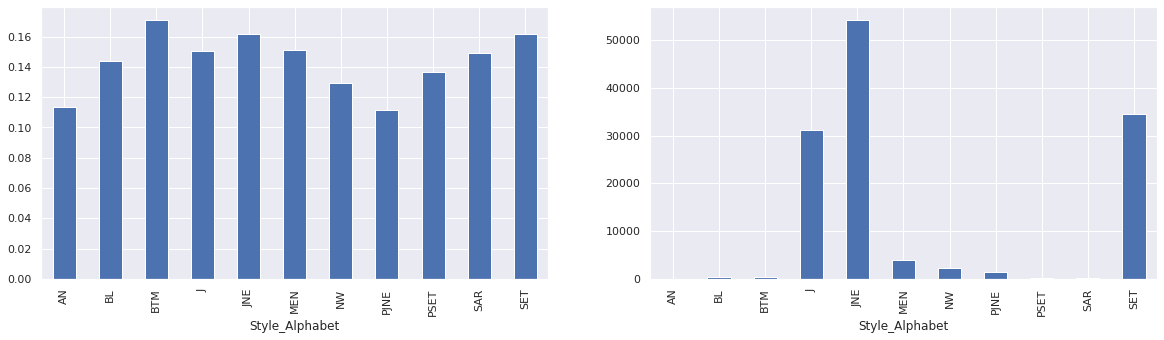

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

cancelled_style_prop.sort_values()[enough_style_alphabet.index].plot(kind='bar', ax = axes[0])
ama_sale.groupby("Style_Alphabet")["index"].count()[enough_style_alphabet.index].plot(kind = 'bar', ax = axes[1])

앞에서 style_alphatbet 순위를 매겼을 때 JNE, SET, J 세개가 가장 눈에 띄었지.
그러면 이 세개랑 fulfilment를 비교해보자

In [ ]:
l = k[(k['Style_Alphabet'] == "JNE")|(k['Style_Alphabet'] == "SET")|(k['Style_Alphabet'] == "J")]; l.head()

,Style_Alphabet,index
Date,,
2022-03-31,J,33
2022-03-31,JNE,76
2022-03-31,SET,50
2022-04-01,J,315
2022-04-01,JNE,563


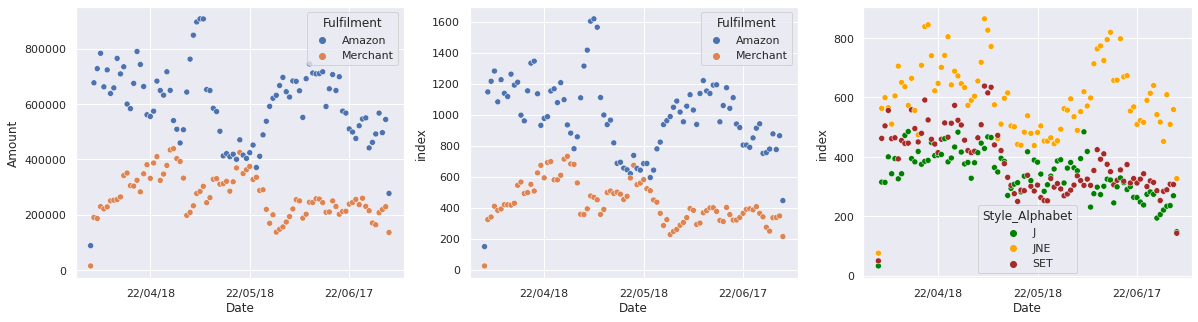

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

sum_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["Amount"].sum().to_frame().reset_index(level = "Fulfilment")
count_ama_fulfil_sale = ama_sale.groupby(["Date", "Fulfilment"])["index"].count().to_frame().reset_index(level = "Fulfilment")


sns.scatterplot(x = "Date", y = 'Amount', data = sum_ama_fulfil_sale, hue = "Fulfilment", ax = axes[0])
sns.scatterplot(x = "Date", y = 'index', data = count_ama_fulfil_sale, hue = "Fulfilment", ax = axes[1])
sns.scatterplot(x = "Date", y = 'index', data = l, hue = "Style_Alphabet", ax = axes[2], palette=['green','orange','brown'])

for i in range(3):
  axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=30))
  axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))

(array([19083., 19097., 19113., 19127., 19144., 19158., 19174.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

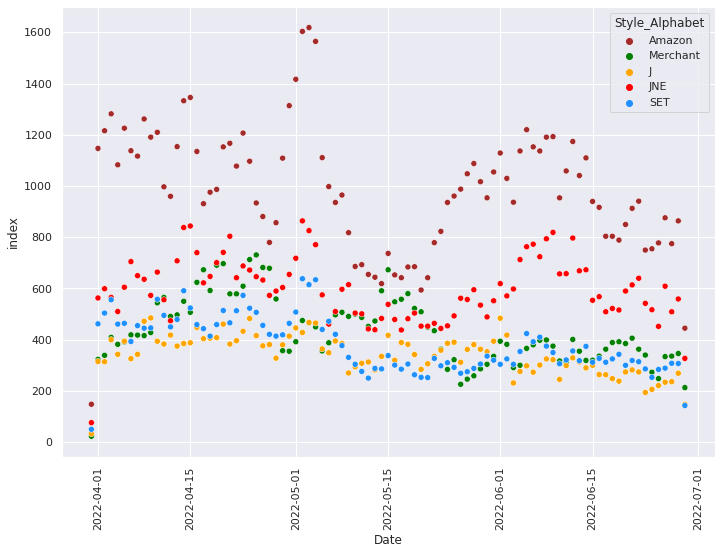

In [ ]:
color_dict = dict({'Amazon':'brown',
                  'Merchant':'green',
                  'J': 'orange',
                  'JNE': 'red',
                   'SET': 'dodgerblue'})

sns.scatterplot(x = "Date", y = 'index', data = count_ama_fulfil_sale, hue = "Fulfilment", palette=color_dict)
sns.scatterplot(x = "Date", y = 'index', data = l, hue = "Style_Alphabet", palette = color_dict)
plt.xticks(rotation='vertical')

# statistical inference calculator

In [ ]:
# ex 4.4.3
from statistics import quantiles
a = [13, 5, 202, 15, 99, 4, 67, 83, 36, 11, 301, 
     23, 213, 40, 66, 106, 78, 69, 166, 84, 64]
a.sort()

print(min(a), [round(i, 2) for i in quantiles(a, n=4)], max(a))

4 [19.0, 67.0, 102.5] 301


# Programmers

In [ ]:
def solution(money):
    num = money//5500
    change = money%5500
    answer = [num, change]
    return answer
solution(14000)


[2, 3000]

IndentationError: ignored